## Load Packages & Define Constants

In [1]:
import os, os.path
import numpy as np
import matplotlib.pyplot as plt

""" Sort data access in this order (Will need this order for other parts) """
data_sets = ['alpha', 'beta', 'delta']
dir_path = os.getcwd()

## 3a.) Visualize first three training data with each data sets in subplots

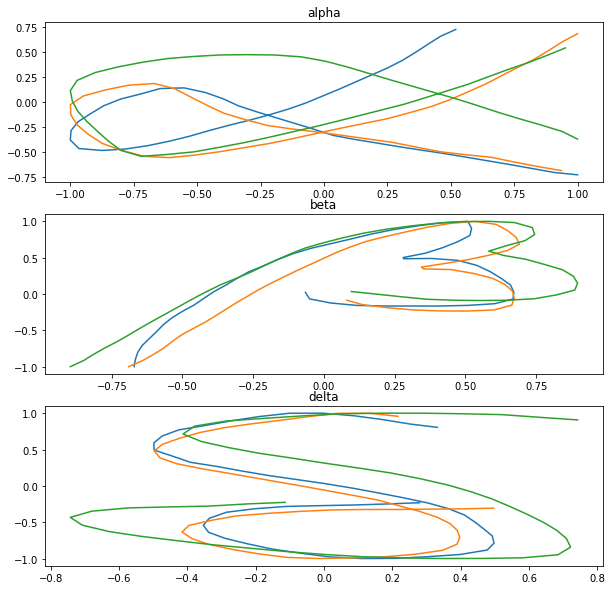

In [2]:
""" This path algorithm assumes you have python file, data folder in the same directory """ 
fig, _ = plt.subplots(nrows=3, ncols=1, figsize =(10,10))
for i in range(len(data_sets)):
    temp = 311+i
    plt.subplot(temp)
    plt.title(data_sets[i])
    for j in range(1, 4):
        new_path = str(dir_path) + "\Data\\" + str(data_sets[i])
        filename = new_path + "\\t" + str(j) + ".txt"
        x, y = np.loadtxt(filename, delimiter=' ', unpack=True)
        plt.plot(x, y)

plt.show()

## 3b.) Defining features

I defined my feature to be the following ($ s_p $ = starting point, $ e_p $ = ending point): <br>
1.) $ x_1 = avg(tan^{-1}(y_i/x_i)) $, 2.) $ x_2 = tan^{-1}(s_{p,y} - e_{p,y}/s_{p,x} - e_{p,x}) $, 3.) $ x_3 = \Large \frac{\left\lvert s_{p,y} - e_{p,y} \right\rvert}{height} $ <br>
<br>
The first feature tries to determine the average curvature of each characters by taking the average angle made from individual points w.r.t. origin  <br>
<br>
The second feature determines the angle made from the starting point to the ending point <br>
<br>
The last feature figures out the ratio of the vertical difference between start & end point and the overall height of the writing box. This is a distinct feature that hopefully distinguishes alpha over the rest of the characters as I observe the greatest ratio.

In [3]:
feats = np.ndarray((len(data_sets), 3)) # array of size (# of characters, # of features)

for i in range(len(data_sets)):
    filename = str(dir_path) + "\Data\\" + str(data_sets[i]) + "\\t1.txt"
    x, y = np.loadtxt(filename, delimiter=' ', unpack=True)
    feats[i] = np.array([np.mean(np.arctan2(y, x)), np.arctan2((y[0] - y[-1]), (x[0] - x[-1])), np.abs(y[0] - y[-1])/2])

print(feats)

[[-0.81556743  1.88894942  0.729258  ]
 [ 0.12949001 -2.10531296  0.5115715 ]
 [-0.01714396  1.52083798  0.5188105 ]]


## 3c.) Calculate mean and covariance from feature vectors of all samples

In [4]:
""" Get the total number of files expected within "Data" folder, this is to make an array of that size """ 
numFiles = np.empty((len(data_sets), 1), dtype=int)
for i in range(len(data_sets)):
    new_path = str(dir_path) + "\Data\\" + str(data_sets[i])
    os.chdir(new_path)
    numFiles[i] = len([name for name in os.listdir('.') if os.path.isfile(name)])

In [5]:
""" Now that we know how many test files are we expecting to loop through, initialize an empty matrix of size (# of test files, # of features) 
Outer loop: [alpha, beta, delta] -> Inner loop: [t1.txt, t2.txt, ....] """
feats = np.empty((np.sum(numFiles), 3))
c = 0
for i in range(len(data_sets)):
    new_path = str(dir_path) + "\Data\\" + str(data_sets[i])
    os.chdir(new_path)
    for j in range(1, int(numFiles[i] + 1)):
        filename = new_path + "\\t" + str(j) + ".txt"
        x, y = np.loadtxt(filename, delimiter=' ', unpack=True)
        feats[c] = np.array([np.mean(np.arctan2(y, x)), np.arctan2((y[0] - y[-1]), (x[0] - x[-1])), np.abs(y[0] - y[-1])/2])
        c += 1

In [6]:
""" We expect 3 vectors of means for each character, each vector represents the means of each feature (# of character, # of features) """ 
means = np.empty((len(numFiles), 3))

""" We expect a covariance matrix for each character, each is a square matrix of size (# of test for character, # of test for character) """ 
cov_alpha = np.empty((3, 3))
cov_beta = np.empty((3, 3))
cov_delta = np.empty((3, 3))

""" Algorithm to split up the feats matrix, so we can calculate the mean matrix and covariance matrix of each characters """ 
""" Part of 3d.) is solved here for convenience: p(x|w_i) """
c = 0
for i, num in enumerate(numFiles):
    means[i] = np.mean(feats[int(c):int(c+num)], axis=0)
    temp = feats[int(c):int(c+num)] - means[i]

    if c < int(numFiles[0]):
        cov_alpha = temp.T @ temp / num
        p_alpha = 1/(np.power(2*np.pi, 1.5) * np.sqrt(np.linalg.det(cov_alpha))) * np.exp(-0.5 * temp @ np.linalg.inv(cov_alpha) @ temp.T)
    elif c < int(numFiles[0] + numFiles[1]) and c >= int(num[0]):
        cov_beta = temp.T @ temp / num
        p_beta = 1/(np.power(2*np.pi, 1.5) * np.sqrt(np.linalg.det(cov_beta))) * np.exp(-0.5 * temp @ np.linalg.inv(cov_beta) @ temp.T)
    elif c < int(numFiles[0] + numFiles[1] + numFiles[2]) and c >= int(numFiles[0] + numFiles[1]):
        cov_delta = temp.T @ temp / num
        p_delta = 1/(np.power(2*np.pi, 1.5) * np.sqrt(np.linalg.det(cov_delta))) * np.exp(-0.5 * temp @ np.linalg.inv(cov_delta) @ temp.T)

    c = c + num

In [7]:
""" Print results """
for i in range(len(means)):
    print("Feature means in {}: {}\n".format(data_sets[i], means[i]))

print("Covariance matrix of alpha = {}\n".format(cov_alpha))
print("Covariance matrix of beta = {}\n".format(cov_beta))
print("Covariance matrix of delta = {}\n".format(cov_delta))

Feature means in alpha: [-0.31894682  1.8272186   0.66012027]

Feature means in beta: [ 0.16499742 -2.09149328  0.50013245]

Feature means in delta: [-0.18102416  1.61798779  0.51458067]

Covariance matrix of alpha = [[ 0.09624981  0.01171338 -0.01792393]
 [ 0.01171338  0.02153563  0.00309751]
 [-0.01792393  0.00309751  0.0082783 ]]

Covariance matrix of beta = [[0.01592802 0.02614134 0.00134567]
 [0.02614134 0.05202528 0.00120692]
 [0.00134567 0.00120692 0.00184325]]

Covariance matrix of delta = [[ 0.01439073  0.01631996 -0.00089919]
 [ 0.01631996  0.09878927 -0.00154468]
 [-0.00089919 -0.00154468  0.00483236]]



## 3d.) Implementation of Bayesian classifier on test data

In [15]:
""" Prior from testing data """
P_w = numFiles/np.sum(numFiles)

""" Make a new file that saves the prediction and saves it in the same folder as the test data """
newFile = open("test_results.txt", "w+")

""" Opening individual test files and make a prediction """
new_path = str(dir_path) + "\Test"
os.chdir(new_path)
testFiles = len([name for name in os.listdir('.') if os.path.isfile(name)]) # It should print 1 more than our testing data because of test_results.txt
test_pred = np.empty((int(testFiles - 1), 1)) # testFiles - 1 to account for test_results.txt

for i in range(1, int(testFiles)):
    filename = new_path + "\\test" + str(i) + ".txt"
    testX, testY = np.loadtxt(filename, delimiter=' ', unpack=True)
    test_feat = np.array([np.mean(np.arctan2(testY, testX)), np.arctan2((testY[0] - testY[-1]), (testX[0] - testX[-1])), np.abs(testY[0] - testY[-1])/2])

    test_for_alpha = test_feat - means[0]
    pred_alpha = 1/(np.power(2*np.pi, 1.5) * np.sqrt(np.linalg.det(cov_alpha))) * np.exp(-0.5 * test_for_alpha @ np.linalg.inv(cov_alpha) @ test_for_alpha.T)

    test_for_beta = test_feat - means[1]
    pred_beta = 1/(np.power(2*np.pi, 1.5) * np.sqrt(np.linalg.det(cov_beta))) * np.exp(-0.5 * test_for_beta @ np.linalg.inv(cov_beta) @ test_for_beta.T)

    test_for_delta = test_feat - means[2]
    pred_delta = 1/(np.power(2*np.pi, 1.5) * np.sqrt(np.linalg.det(cov_delta))) * np.exp(-0.5 * test_for_delta @ np.linalg.inv(cov_delta) @ test_for_delta.T)

    test_pred[i-1] = np.argmax([P_w[0]*pred_alpha, P_w[1]*pred_beta, P_w[2]*pred_delta]) # Bayes Rule

""" Writing the result into the txt file we created above """
for j in range(len(test_pred)):
    newFile.write("Prediction for test{}.txt = {}.\n".format(int(j+1), int(test_pred[j]+1)))

newFile.close()
